# Model with non-grey clouds, Guillot profile and disequilibrium chemistry

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import petitRADTRANS as prt
from petitRADTRANS.retrieval.models import guillot_transmission
from petitRADTRANS import physical_constants as cst
from petitRADTRANS.retrieval import Retrieval,RetrievalConfig
from petitRADTRANS.retrieval.models import Planet
from petitRADTRANS.retrieval.utils import log_prior
from matplotlib.patches import Rectangle
from petitRADTRANS.plotlib import plot_radtrans_opacities

from petitRADTRANS.retrieval.models import ( guillot_transmission, guillot_patchy_transmission )
from petitRADTRANS.retrieval.parameter import Parameter
from petitRADTRANS.plotlib.style import set_petitradtrans_plot_style

import os
root_path = os.path.abspath(os.path.join(os.getcwd(), "../../"))
multinest_path = os.path.abspath(os.path.join(os.getcwd(), "../../../MultiNest/lib"))
output_directory = os.path.join(root_path, "outputs")

os.environ["OMP_NUM_THREADS"] = "8"
os.environ["DYLD_LIBRARY_PATH"] = multinest_path
os.environ["LD_LIBRARY_PATH"] = multinest_path

set_petitradtrans_plot_style()
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12 
%matplotlib inline

Using pRT Plotting style!


In [2]:
planet = Planet.get("K2-18 b")

retrieval_config = RetrievalConfig(retrieval_name="K2-18b_guillot_non_grey_clouds_disequilibrium",
                                run_mode="retrieve",
                                amr=False,
                                scattering_in_emission=True,
                                pressures=np.logspace(-6, 2, 120),
                                  )

retrieval_config.add_data(
    "K2-18b_NIRISS",
    os.path.join(root_path, "spectra/K2-18b_NIRISS.txt"),
    data_resolution=700,
    model_resolution=1500,
    model_generating_function=guillot_transmission,
    line_opacity_mode="c-k",
    external_radtrans_reference=None
)

retrieval_config.add_data(
    "K2-18b_NIRSPEC",
    os.path.join(root_path, "spectra/K2-18b_NIRSPEC.txt"),
    data_resolution=2700,
    model_resolution=1500,
    model_generating_function=guillot_transmission,
    line_opacity_mode="c-k",
    external_radtrans_reference=None
)

retrieval_config.add_parameter('D_pl', False, value=124.265*cst.light_year)
retrieval_config.add_parameter('stellar_radius', False, value=planet.star_radius)
retrieval_config.add_parameter('planet_radius', False, value = 0.211*cst.r_jup)
retrieval_config.add_parameter('mass', False, value = 0.02807*cst.m_jup)

retrieval_config.add_parameter('T_int', True, transform_prior_cube_coordinate = lambda x : 600*x)
retrieval_config.add_parameter('T_equ', True, transform_prior_cube_coordinate = lambda x : 600*x)
retrieval_config.add_parameter('gamma', True, transform_prior_cube_coordinate = lambda x : log_prior(x, -2, 1))
retrieval_config.add_parameter('log_kappa_IR', True, transform_prior_cube_coordinate = lambda x : -3+4*x)
retrieval_config.add_parameter('fsed_H2O(l)', True, transform_prior_cube_coordinate = lambda x: log_prior(x, -3, 0))
retrieval_config.add_parameter('log_kzz', True, transform_prior_cube_coordinate = lambda x: 4+8*x)
retrieval_config.add_parameter('log_X_cb_H2O(l)', True, transform_prior_cube_coordinate = lambda x: -6+6*x)
retrieval_config.add_parameter('sigma_lnorm', True, transform_prior_cube_coordinate = lambda x: 1.05+1.95*x)
retrieval_config.add_parameter('log_Pbase_H2O(l)',  True, transform_prior_cube_coordinate = lambda x: -5+5*x)
retrieval_config.add_parameter('patchiness', True, transform_prior_cube_coordinate = lambda x: 1*x)
retrieval_config.add_parameter('C/O', True, transform_prior_cube_coordinate = lambda x: 0.2 + 1*x)
retrieval_config.add_parameter('Fe/H', True, transform_prior_cube_coordinate = lambda x: 0+3*x)
retrieval_config.add_parameter('log_pquench', True, transform_prior_cube_coordinate = lambda x: -6+8*x)

retrieval_config.set_rayleigh_species(['H2', 'He'])
retrieval_config.set_continuum_opacities(["H2-H2","H2-He"])
retrieval_config.add_cloud_species('H2O(l)', eq=True)

retrieval_config.parameters['T_int'].plot_in_corner = True
retrieval_config.parameters['T_int'].corner_ranges = (0,600)
retrieval_config.parameters['T_equ'].plot_in_corner = True
retrieval_config.parameters['T_equ'].corner_ranges = (0,600)
retrieval_config.parameters['gamma'].plot_in_corner = True
retrieval_config.parameters['gamma'].corner_ranges = (-2,6)
retrieval_config.parameters['log_kappa_IR'].plot_in_corner = True
retrieval_config.parameters['log_kappa_IR'].corner_ranges = (-3,1)
retrieval_config.parameters['log_X_cb_H2O(l)'].plot_in_corner = True
retrieval_config.parameters['log_X_cb_H2O(l)'].corner_ranges = (-6,0)
retrieval_config.parameters['fsed_H2O(l)'].plot_in_corner = True
retrieval_config.parameters['fsed_H2O(l)'].corner_ranges = (0,1)
retrieval_config.parameters['sigma_lnorm'].plot_in_corner = True
retrieval_config.parameters['sigma_lnorm'].corner_ranges = (1.05,3)
retrieval_config.parameters['log_Pbase_H2O(l)'].plot_in_corner = True
retrieval_config.parameters['log_Pbase_H2O(l)'].corner_ranges = (-5,2)

for spec in retrieval_config.line_species:
    retrieval_config.parameters[spec].plot_in_corner = True
    retrieval_config.parameters[spec].corner_ranges = (-8.2,0.2)

retrieval_config.plot_kwargs["spec_xlabel"] = 'Wavelength [micron]'
retrieval_config.plot_kwargs["spec_ylabel"] = r'$(R_{\rm P}/R_*)^2$ [ppm]'
retrieval_config.plot_kwargs["y_axis_scaling"] = 1e6 # so we have units of ppm
retrieval_config.plot_kwargs["xscale"] = 'linear'
retrieval_config.plot_kwargs["yscale"] = 'linear'

# Use at least ~100 samples to plot 3 sigma curves
retrieval_config.plot_kwargs["nsample"] = 100

retrieval_config.plot_kwargs["take_PTs_from"] = "K2-18b_NIRISS"
retrieval_config.plot_kwargs["temp_limits"] = [100, 800]
retrieval_config.plot_kwargs["press_limits"] = [1e-6, 1e2]

retrieval = Retrieval(retrieval_config,
                      output_directory=output_directory,
                      use_mpi = False,        # Run locally, don't need to use MPI for massive parallelisation
                      evaluate_sample_spectra=False,      # Output the spectrum from nsample random samples.
                      use_prt_plot_style=True,
                      ultranest=False)        # Let's use pyMultiNestopacities = plot_radtrans_opacities(

retrieval.run(n_live_points=100,         # PMN number of live points. 400 is good for small retrievals, 4000 for large
              const_efficiency_mode=False, # Turn PMN const efficiency mode on or off (recommend on for large retrievals)
              resume=True,
              error_checking=False) 

Setting up Radtrans object for data 'K2-18b_NIRISS'...
Loading Radtrans opacities...
 Loading CIA opacities for H2-H2 from file '/Users/felipemustafa/Documents/interplay/petit/input_data/opacities/continuum/collision_induced_absorptions/H2--H2/H2--H2-NatAbund/H2--H2-NatAbund__BoRi.R831_0.6-250mu.ciatable.petitRADTRANS.h5'... Done.
 Loading CIA opacities for H2-He from file '/Users/felipemustafa/Documents/interplay/petit/input_data/opacities/continuum/collision_induced_absorptions/H2--He/H2--He-NatAbund/H2--He-NatAbund__BoRi.DeltaWavenumber2_0.5-500mu.ciatable.petitRADTRANS.h5'... Done.
 Successfully loaded all CIA opacities
 Loading opacities of cloud species 'H2O(l)' from file '/Users/felipemustafa/Documents/interplay/petit/input_data/opacities/continuum/clouds/H2O(l)/H2-O-NatAbund(l)/H2-O-NatAbund(l)__Mie.R39_0.1-250mu.cotable.petitRADTRANS.h5' (_Mie.R39_0.1-250mu.cotable.petitRADTRANS.h5, using Mie scattering)... Done.
 Successfully loaded all clouds opacities
Successfully loaded al

/Users/felipemustafa/Documents/interplay/petit/prt/lib/python3.13/site-packages/petitRADTRANS/retrieval/retrieval.py:117: UserWarning: there are no line species present in the run definition
  warnings.warn("there are no line species present in the run definition")


In [4]:
## Getting samples
sample_dict, parameter_dict = retrieval.get_samples(output_directory=output_directory)
samples_use = sample_dict[retrieval.configuration.retrieval_name]
parameters_read = parameter_dict[retrieval.configuration.retrieval_name]

## Getting the best-fit model
log_l, best_fit_index = retrieval.get_best_fit_likelihood(samples_use)
sample_use = samples_use[:-1, best_fit_index]

best_fit_wavelengths, best_fit_spectrum = retrieval.get_best_fit_model(
                sample_use,
                parameters_read,
                model_generating_function=guillot_transmission,
            )

Best fit likelihood = 28815.46
Loading Radtrans opacities...
 Loading CIA opacities for H2-H2 from file '/Users/felipemustafa/Documents/interplay/petit/input_data/opacities/continuum/collision_induced_absorptions/H2--H2/H2--H2-NatAbund/H2--H2-NatAbund__BoRi.R831_0.6-250mu.ciatable.petitRADTRANS.h5'... Done.
 Loading CIA opacities for H2-He from file '/Users/felipemustafa/Documents/interplay/petit/input_data/opacities/continuum/collision_induced_absorptions/H2--He/H2--He-NatAbund/H2--He-NatAbund__BoRi.DeltaWavenumber2_0.5-500mu.ciatable.petitRADTRANS.h5'... Done.
 Successfully loaded all CIA opacities
 Loading opacities of cloud species 'H2O(l)' from file '/Users/felipemustafa/Documents/interplay/petit/input_data/opacities/continuum/clouds/H2O(l)/H2-O-NatAbund(l)/H2-O-NatAbund(l)__Mie.R39_0.1-250mu.cotable.petitRADTRANS.h5' (_Mie.R39_0.1-250mu.cotable.petitRADTRANS.h5, using Mie scattering)... Done.
 Successfully loaded all clouds opacities
Successfully loaded all opacities
Done.ng chem

<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:3: SyntaxWarning: invalid escape sequence '\s'
<>:34: SyntaxWarning: invalid escape sequence '\c'
<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:3: SyntaxWarning: invalid escape sequence '\s'
<>:34: SyntaxWarning: invalid escape sequence '\c'
/var/folders/7n/vnhc1_6x3xsdp541n54p1r9c0000gn/T/ipykernel_16651/2398162007.py:2: SyntaxWarning: invalid escape sequence '\s'
  niriss = pd.read_csv(os.path.join(root_path, "spectra/K2-18b_NIRISS_low_res.txt"), skiprows=1, names=["wl", "td", "td_e"], sep="\s+")
/var/folders/7n/vnhc1_6x3xsdp541n54p1r9c0000gn/T/ipykernel_16651/2398162007.py:3: SyntaxWarning: invalid escape sequence '\s'
  nirspec = pd.read_csv(os.path.join(root_path, "spectra/K2-18b_NIRSPEC_low_res.txt"), skiprows=1, names=["wl", "td", "td_e"], sep="\s+")
/var/folders/7n/vnhc1_6x3xsdp541n54p1r9c0000gn/T/ipykernel_16651/2398162007.py:34: SyntaxWarning: invalid escape sequence '\c'
  ax.set_title(f'Best fit spectra, $\chi_v^2$

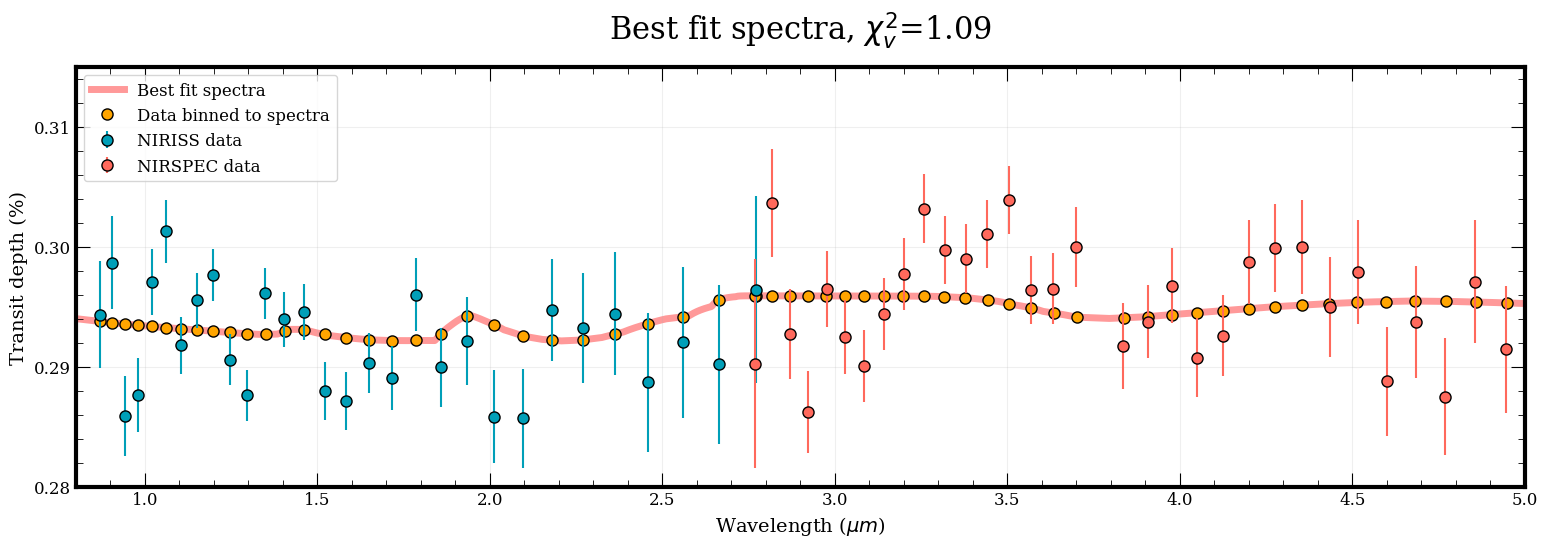

In [5]:
## Loading the low resolution spectra
niriss = pd.read_csv(os.path.join(root_path, "spectra/K2-18b_NIRISS_low_res.txt"), skiprows=1, names=["wl", "td", "td_e"], sep="\s+")
nirspec = pd.read_csv(os.path.join(root_path, "spectra/K2-18b_NIRSPEC_low_res.txt"), skiprows=1, names=["wl", "td", "td_e"], sep="\s+")

## Binning the best fit model to spectra data
idx_niriss = []
idx_nirspec = []
for i in range(niriss["wl"].shape[0]):
    minIndex = np.argmin((best_fit_wavelengths-niriss["wl"][i])**2)
    idx_niriss.append(minIndex)
    
for j in range(nirspec["wl"].shape[0]):
    minIndex = np.argmin((best_fit_wavelengths-nirspec["wl"][j])**2)
    idx_nirspec.append(minIndex)

## Calculating the reduced chi squared
chi2 = retrieval.get_reduced_chi2_from_model(best_fit_wavelengths, best_fit_spectrum, subtract_n_parameters = True)

## Plot of the best-fit spectra
ax = plt.figure(figsize=(16,6)).gca()
ax.plot(best_fit_wavelengths, best_fit_spectrum*100, 
        color="red", alpha=0.4, linewidth=5, zorder=1, label="Best fit spectra")
ax.plot(best_fit_wavelengths[idx_niriss], best_fit_spectrum[idx_niriss]*100, 'o',
          color="orange", markeredgecolor="k", zorder=2, label="Data binned to spectra")
ax.plot(best_fit_wavelengths[idx_nirspec], best_fit_spectrum[idx_nirspec]*100, 'o',
          color="orange", markeredgecolor="k", zorder=2)
ax.errorbar(niriss["wl"], niriss["td"]*100, yerr = niriss["td_e"]*100, fmt='o', markeredgecolor="k", label="NIRISS data", zorder=3)
ax.errorbar(nirspec["wl"], nirspec["td"]*100, yerr = nirspec["td_e"]*100, fmt='o', markeredgecolor="k", label="NIRSPEC data", zorder=3)
ax.set(xlim=(0.8, 5),
       xticks=np.arange(1, 5.5, 0.5), 
       ylim=(0.28, 0.315),
       yticks=[0.28, 0.29, 0.30, 0.31],
      )
ax.set_title(f'Best fit spectra, $\chi_v^2$={chi2:.2f}', pad = 20, fontsize=22)
ax.set_ylabel('Transit depth (%)', fontsize=14)
ax.set_xlabel(r'Wavelength (${\mu m}$)', fontsize=14)
ax.grid(alpha=0.2)
ax.legend(loc="upper left", fontsize=12)
plt.show()

In [6]:
parameters = {
    'stellar_radius': Parameter('stellar_radius', False, value= planet.star_radius),
    'planet_radius': Parameter('planet_radius', False, value= 0.211*cst.r_jup),
    'mass': Parameter('mass', False, value= 0.02807*cst.m_jup),
    'C/O': Parameter('C/O', False, value= retrieval.best_fit_parameters['C/O'].value),
    'Fe/H': Parameter('Fe/H', False, value= retrieval.best_fit_parameters['Fe/H'].value),
    'log_pquench': Parameter('log_pquench', False, value= retrieval.best_fit_parameters['log_pquench'].value),
    'T_int': Parameter('T_int', False, value= retrieval.best_fit_parameters['T_int'].value),
    'T_equ': Parameter('T_equ', False, value= retrieval.best_fit_parameters['T_equ'].value),
    'gamma': Parameter('gamma', False, value= retrieval.best_fit_parameters['gamma'].value),
    'log_kappa_IR': Parameter('log_kappa_IR', False, value= retrieval.best_fit_parameters['log_kappa_IR'].value),
    'log_X_cb_H2O(l)': Parameter('log_X_cb_H2O(l)', False, value = retrieval.best_fit_parameters['log_X_cb_H2O(l)'].value),
    'fsed_H2O(l)': Parameter('fsed_H2O(l)', False, value = retrieval.best_fit_parameters['fsed_H2O(l)'].value),
    'log_Pbase_H2O(l)': Parameter('log_Pbase_H2O(l)', False, value = retrieval.best_fit_parameters['log_Pbase_H2O(l)'].value),
    'log_kzz': Parameter('log_kzz', False, value = retrieval.best_fit_parameters['log_kzz'].value),
    'sigma_lnorm': Parameter('sigma_lnorm', False, value = retrieval.best_fit_parameters['sigma_lnorm'].value),
    'patchiness': Parameter('patchiness', False, value= retrieval.best_fit_parameters['patchiness'].value),
}

line_species = []

rayleigh_species = ['H2', 'He']
continuum_opacities = ['H2-H2', 'H2-He']
cloud_species = []
pressures = np.logspace(-6,2,100)
wls = np.concatenate([retrieval_config.data['K2-18b_NIRISS'].wavelengths, retrieval_config.data['K2-18b_NIRSPEC'].wavelengths])

atmosphere = prt.radtrans.Radtrans(
    pressures=pressures,
    line_species=line_species,
    rayleigh_species=rayleigh_species,
    gas_continuum_contributors=continuum_opacities,
    cloud_species=cloud_species,
    wavelength_boundaries=[wls[0], wls[-1]]
)

wavelength, model = guillot_transmission(atmosphere, parameters, amr = False, pt_plot_mode = False)
pressure,temperature = guillot_transmission(atmosphere, parameters, amr = False, pt_plot_mode = True)

Loading Radtrans opacities...
 Loading CIA opacities for H2-H2 from file '/Users/felipemustafa/Documents/interplay/petit/input_data/opacities/continuum/collision_induced_absorptions/H2--H2/H2--H2-NatAbund/H2--H2-NatAbund__BoRi.R831_0.6-250mu.ciatable.petitRADTRANS.h5'... Done.
 Loading CIA opacities for H2-He from file '/Users/felipemustafa/Documents/interplay/petit/input_data/opacities/continuum/collision_induced_absorptions/H2--He/H2--He-NatAbund/H2--He-NatAbund__BoRi.DeltaWavenumber2_0.5-500mu.ciatable.petitRADTRANS.h5'... Done.
 Successfully loaded all CIA opacities
Successfully loaded all opacities


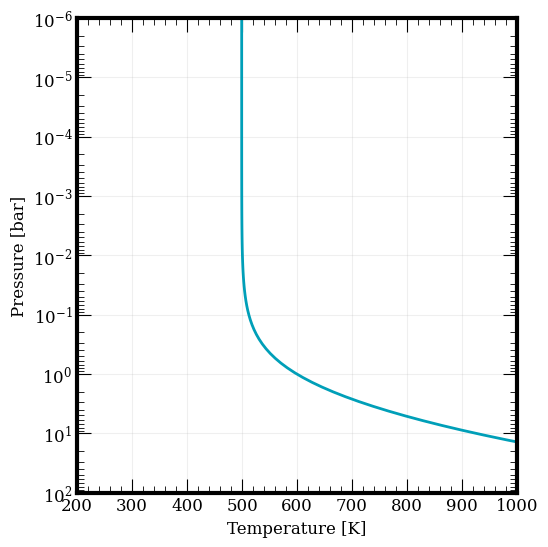

In [7]:
fig, ax = plt.subplots(figsize=(6,6))
ax.plot(temperature, pressure, linewidth = 2)
ax.set_xlabel("Temperature [K]")
ax.set_ylabel(r"Pressure [bar]")
ax.set_ylim(1e2,1e-6)
ax.set_xlim(200, 1000)
ax.set_yscale('log')
ax.set()
ax.grid(alpha=0.2)
plt.show()

In [8]:
## Corner plot
retrieval.plot_corner(sample_dict, parameter_dict, parameters_read, plot_best_fit=True,title_kwargs= {"fontsize" : 10})
plt.show()

Not in evaluate mode. Changing run mode to evaluate.

Making corner plot


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (13,) + inhomogeneous part.

Loading chemical equilibrium chemistry table from file '/Users/felipemustafa/Documents/interplay/petit/input_data/pre_calculated_chemistry/equilibrium_chemistry/equilibrium_chemistry.chemtable.petitRADTRANS.h5'... Done.


Text(0, 0.5, 'P (bar)')

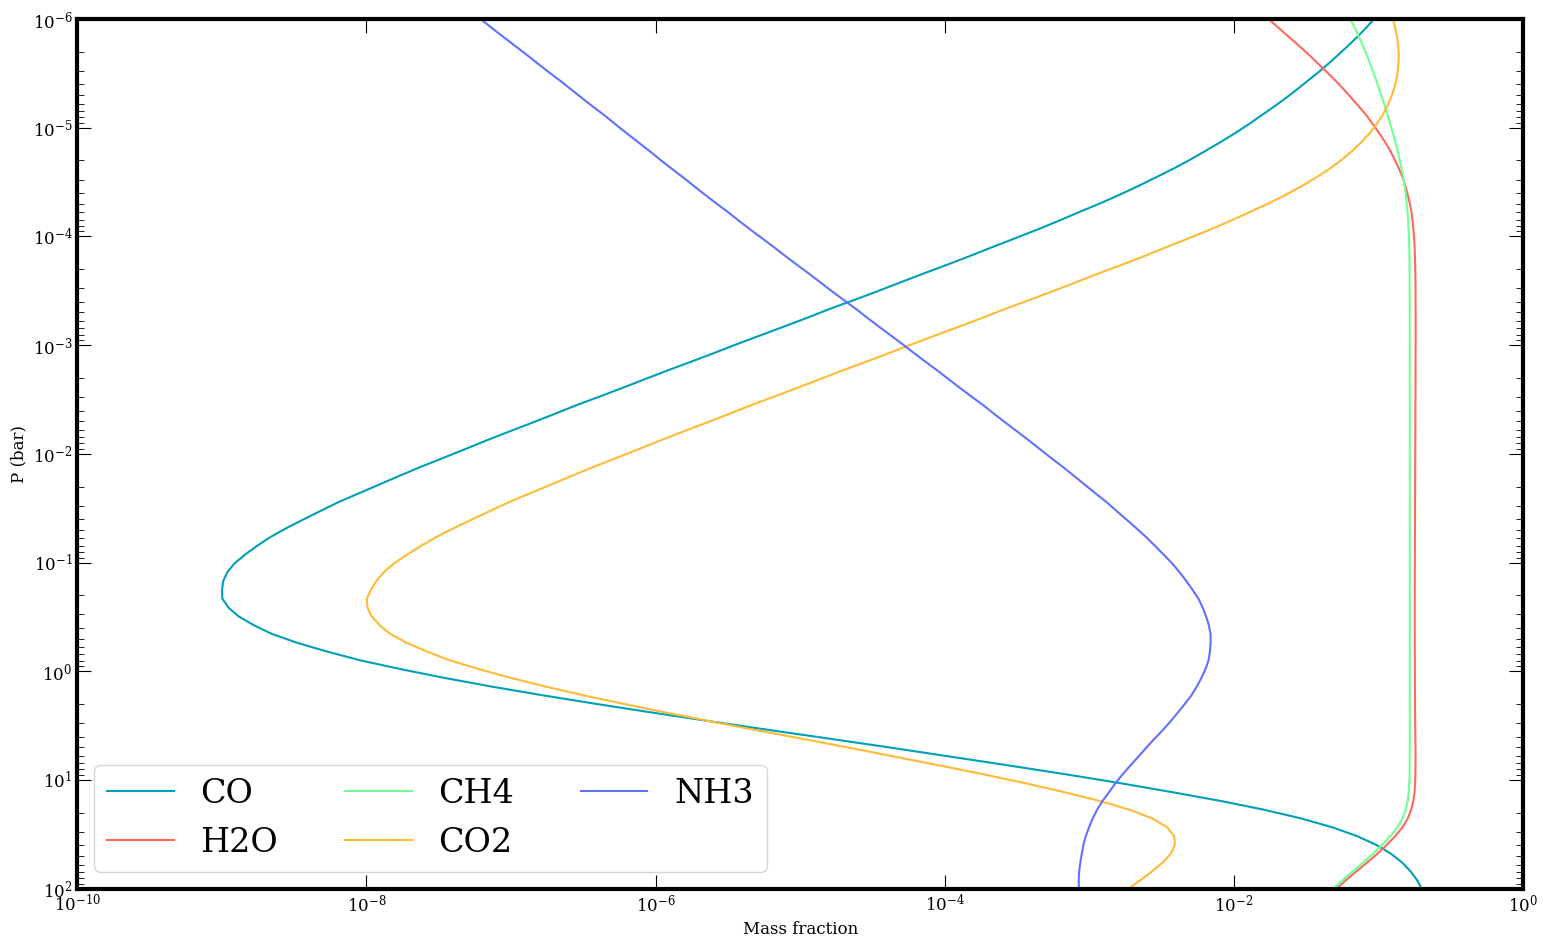

In [14]:
from petitRADTRANS.chemistry.pre_calculated_chemistry import PreCalculatedEquilibriumChemistryTable
chem = PreCalculatedEquilibriumChemistryTable()

co_ratios = retrieval.best_fit_parameters['C/O'].value * np.ones_like(pressures)
log10_metallicities = retrieval.best_fit_parameters['Fe/H'].value * np.ones_like(pressures)

mass_fractions, mean_molar_mass, nabla_ad = chem.interpolate_mass_fractions(
    co_ratios=co_ratios,
    log10_metallicities=log10_metallicities,
    temperatures=temperature,
    pressures=pressure,
    full=True
)

plt.yscale('log')
plt.xscale('log')
plt.ylim([100, 1e-6])
plt.xlim([1e-10, 1])

# for species in mass_fractions.keys():
for species in ['CO', 'H2O', 'CH4', 'CO2', 'NH3']:
    plt.plot(mass_fractions[species], pressures, label=species)

plt.legend(loc='best', ncol=3)
plt.xlabel('Mass fraction')
plt.ylabel('P (bar)')